In [2]:
from core import *
from database import *
from simulator import *
from visualizer import *
import pandas as pd
import random

from _metrics import *

In [1]:
def estimate_model_size(hidden_size, num_hidden_layers, num_heads, input_dim=32000, output_dim=32000):
    """You may narrow down the combinatorial space like this"""
    if not 2**6 <= hidden_size / num_hidden_layers < 2**10:
        return float("inf")
    """Assumption: the same hidden_size for all hidden layers"""
    embedding = input_dim * hidden_size
    attn = hidden_size * hidden_size * 4 # batchnorm
    ffn = hidden_size * hidden_size * 4 * 2
    layers = num_hidden_layers * (attn + ffn)
    norm = (1 + 2 * num_hidden_layers) * hidden_size
    head = hidden_size * output_dim
    return sum([embedding, layers, head, norm])


cc = Chinchilla(
    "/fsx-onellm/margaretli/env_srcs/xlf/xlformers_n/scaling/tmp",
    param_grid=dict(
        E=np.linspace(1.1, 1.5, 5),
        A=np.linspace(200, 1000, 5),
        B=np.linspace(200, 1000, 5),
        alpha=np.linspace(0.1, 0.5, 5),
        beta=np.linspace(0.1, 0.5, 5),
    ),
    seed_ranges=dict(C=(1e16, 1e18), N_to_D=(10, 100)),
    # To search for the model configuration with N closest to suggested:
    model_search_config=dict(
        hyperparam_grid=dict(
            hidden_size=list(range(64, 16384 + 1, 64)),
            num_hidden_layers=list(range(1, 50 + 1)),
            num_heads=list(range(1, 40 + 1)),
        ),
        size_estimator=estimate_model_size,  # You gotta define a function to estimate & return model size also
    ),
    # Parameters you may pre-set
    num_seeding_steps=100,
    scaling_factor=2.0,
)

cc.simulate(
    num_seeding_steps=101,
    num_scaling_steps=1,
    scaling_factor=2.0,
    target_params=dict(
        E=1.69337368,
        A=406.401018,
        B=410.722827,
        alpha=0.33917084,
        beta=0.2849083
    ),
    # Add exponentially distributed loss averaging at 0.1
    noise_generator=(random.expovariate, (10,))
)

NameError: name 'Chinchilla' is not defined

In [3]:
DEFAULT_PROJECT_DIR = "/fsx-onellm/margaretli/env_srcs/xlf/xlformers_n/scaling/data"

col_names = ['C', 'D', 'N', 'lr', 'Avg Train Loss', 'Max Train Loss', 'C4 Eval PPL', 'Wiki Eval PPL', 'C4 Eval Loss', 'Wiki Eval Loss']

def read_data(csv_file, loss_name='C4 Eval Loss', col_names=col_names):
    mins_only = []
    df = pd.read_csv(csv_file, usecols=col_names,)
    df.dropna(subset=[loss_name], inplace=True)

    df = df.loc[(df['lr'] >= 0)]
    n_vals = df['N'].unique()
    d_vals = sorted(df['D'].unique())
    for n in n_vals:
        for d in d_vals:
            cd_df = df[(df['N'] == n) & (df['D'] == d)]
            if cd_df.empty:
                continue
            min_index = cd_df['C4 Eval Loss'].idxmin()
            # print(min_index)
            # print(cd_df)
            # print(cd_df.loc[min_index])
            mins_only.append(cd_df.loc[min_index])

    mins_only_df = pd.DataFrame(mins_only)

    print(mins_only_df)
    # df.rename(columns={})
    return mins_only_df

In [4]:
loss_name = "C4 Eval Loss"
csv_file = "/fsx-onellm/margaretli/env_srcs/xlf/xlformers_n/scaling/data/data.csv"

fit_df = read_data(csv_file=csv_file, loss_name=loss_name)

for n, d, l in fit_df[['N', 'D', loss_name]].values:
    print(int(n), int(d), round(l, 4), round(cc.predict_loss(n, d), 4))
    n1,d1 = cc.allocate_compute(6* n * d)
    print(int(n1) , int(d1), round(cc.predict_loss(n1, d1), 4))
    print('\n')

        lr  Avg Train Loss  Max Train Loss  C4 Eval PPL  Wiki Eval PPL  \
4    0.004           4.957           5.185      146.194        216.300   
12   0.004           4.717           5.044      119.259        166.031   
17   0.004           4.453           4.659       89.148        115.380   
21   0.004           3.999           4.218       61.665         70.939   
25   0.004           3.736           4.058       46.984         47.592   
29   0.004           3.533           3.764       39.858         35.852   
33   0.002           4.925           5.171      141.632        224.183   
37   0.002           4.683           5.024      114.945        168.517   
42   0.004           3.880           4.109       55.653         62.826   
46   0.004           3.603           3.968       41.767         39.030   
50   0.004           3.448           3.680       36.775         32.393   
54   0.004           3.384           3.679       34.108         29.042   
58   0.004           3.312           3

NameError: name 'cc' is not defined

        lr  Avg Train Loss  Max Train Loss  C4 Eval PPL  Wiki Eval PPL  \
4    0.004           4.957           5.185      146.194        216.300   
12   0.004           4.717           5.044      119.259        166.031   
17   0.004           4.453           4.659       89.148        115.380   
21   0.004           3.999           4.218       61.665         70.939   
25   0.004           3.736           4.058       46.984         47.592   
29   0.004           3.533           3.764       39.858         35.852   
33   0.002           4.925           5.171      141.632        224.183   
37   0.002           4.683           5.024      114.945        168.517   
42   0.004           3.880           4.109       55.653         62.826   
46   0.004           3.603           3.968       41.767         39.030   
50   0.004           3.448           3.680       36.775         32.393   
54   0.004           3.384           3.679       34.108         29.042   
58   0.004           3.312           3

[22:57:36] WARNING  You did not specify `model_search_config`. In order to find a model configuration,  ]8;id=694758;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py\core.py]8;;\:]8;id=995397;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py#106\106]8;;\
                    You will need to either:                                                                       
                    1.  Assign `model_search_config` attribute before calling `seed` method.                       
                    2.  Find the model configuration closest to `N` yourself, and optionally call                  
                    `cc.adjust_D_to_N(N)` when scaling.                                                            

           INFO     Mounting a directory: /fsx-onellm/margaretli/env_srcs/xlf/xlformers_n/scaling/data  ]8;id=21432;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py\core.py]8;;\:]8;id=804956;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py#157\157]8;;\

[22:57:36] INFO     Chinchilla instance created successfully.                                           ]8;id=159175;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py\core.py]8;;\:]8;id=306;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py#162\162]8;;\

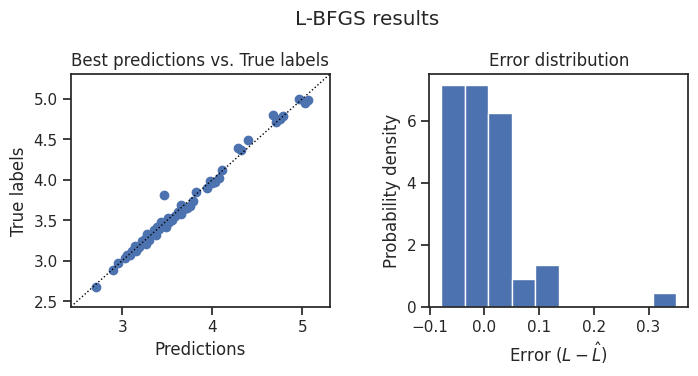

[23:01:20] INFO     Loss predictor:                                                                     ]8;id=988956;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py\core.py]8;;\:]8;id=534413;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py#380\380]8;;\
                                                                                                                   
                      L(N, D) = 1.309 + 4.450 / (N ^ 0.06962) + 1.563e+05 / (D ^ 0.5801)                           
                                                                                                                   

In [9]:
loss_name = "C4 Eval Loss"
csv_file = "/fsx-onellm/margaretli/env_srcs/xlf/xlformers_n/scaling/data/data.csv"
project_dir=DEFAULT_PROJECT_DIR

fit_df = read_data(csv_file=csv_file, loss_name=loss_name)
# fit_df = fit_df[fit_df['N'] < 50000000]


cc = Chinchilla(
    project_dir,
    param_grid=dict(
        E=np.linspace(1, 4, 5),
        A=np.linspace(100, 4000, 5),
        B=np.linspace(100, 4000, 5),
        alpha=np.linspace(0.0, 1, 5),
        beta=np.linspace(0.0, 1, 5),
    ),
    seed_ranges=dict(C=(1e14, 1e20), N_to_D=(10, 120)),
    # Seed models: 10 ^ 14.5~15.5 FLOPS, 64 <= N/D <= 256
    model_search_config=None,
    scaling_factor=2.0,  # Double the compute budget each step (after seed models)
    df=fit_df,
    loss_name=loss_name,
    # weight_fn=lambda x: x**(1/2),
    loss_fn=asymmetric_mae,
)

cc.fit()



         lr  Avg Train Loss  Max Train Loss  C4 Eval PPL  Wiki Eval PPL  \
4    0.0040           4.957           5.185      146.194        216.300   
12   0.0040           4.717           5.044      119.259        166.031   
17   0.0040           4.453           4.659       89.148        115.380   
21   0.0040           3.999           4.218       61.665         70.939   
25   0.0040           3.736           4.058       46.984         47.592   
..      ...             ...             ...          ...            ...   
268  0.0020           2.899           3.182       21.522         16.467   
272  0.0020           2.864           3.263       20.629         15.535   
276  0.0020           2.815           3.157       19.575         14.377   
286  0.0010           2.725           3.060       17.837         12.987   
295  0.0008           2.487           2.915       14.389          9.577   

     C4 Eval Loss  Wiki Eval Loss             C             D            N  
4           4.985     

[22:53:18] WARNING  You did not specify `model_search_config`. In order to find a model configuration,  ]8;id=904048;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py\core.py]8;;\:]8;id=523010;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py#106\106]8;;\
                    You will need to either:                                                                       
                    1.  Assign `model_search_config` attribute before calling `seed` method.                       
                    2.  Find the model configuration closest to `N` yourself, and optionally call                  
                    `cc.adjust_D_to_N(N)` when scaling.                                                            

           INFO     Mounting a directory: /fsx-onellm/margaretli/env_srcs/xlf/xlformers_n/scaling/data  ]8;id=418506;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py\core.py]8;;\:]8;id=255674;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py#157\157]8;;\

[22:53:18] INFO     Chinchilla instance created successfully.                                           ]8;id=603863;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py\core.py]8;;\:]8;id=793286;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py#162\162]8;;\

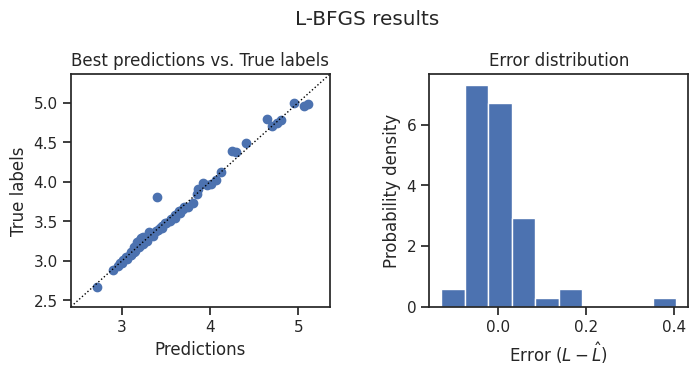

[22:57:35] INFO     Loss predictor:                                                                     ]8;id=909719;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py\core.py]8;;\:]8;id=769386;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py#380\380]8;;\
                                                                                                                   
                      L(N, D) = -4.288 + 10.18 / (N ^ 0.01988) + 2.306e+06 / (D ^ 0.7273)                          
                                                                                                                   

In [8]:
loss_name = "C4 Eval Loss"
csv_file = "/fsx-onellm/margaretli/env_srcs/xlf/xlformers_n/scaling/data/dense.csv"
project_dir=DEFAULT_PROJECT_DIR

fit_df = read_data(csv_file=csv_file, loss_name=loss_name)
# fit_df = fit_df[fit_df['N'] < 50000000]


cc = Chinchilla(
    project_dir,
    param_grid=dict(
        E=np.linspace(1, 4, 4),
        A=np.linspace(100, 4000, 5),
        B=np.linspace(100, 4000, 5),
        alpha=np.linspace(0.0, 1, 5),
        beta=np.linspace(0.0, 1, 5),
    ),
    seed_ranges=dict(C=(1e14, 1e20), N_to_D=(10, 120)),
    # Seed models: 10 ^ 14.5~15.5 FLOPS, 64 <= N/D <= 256
    model_search_config=None,
    scaling_factor=2.0,  # Double the compute budget each step (after seed models)
    df=fit_df,
    loss_name=loss_name,
    # weight_fn=lambda x: x**(1/2),
    loss_fn=asymmetric_mae,
)

cc.fit()



[21:49:44] INFO     Creating a directory: /fsx-onellm/margaretli/env_srcs/xlf/xlformers_n/scaling/tmp2  ]8;id=938091;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py\core.py]8;;\:]8;id=919594;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py#154\154]8;;\

[21:49:44] INFO     Initializing a database to be saved to:                                          ]8;id=412854;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/database.py\database.py]8;;\:]8;id=259959;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/database.py#57\57]8;;\
                    /fsx-onellm/margaretli/env_srcs/xlf/xlformers_n/scaling/tmp2/df.csv                            

[21:49:44] INFO     Chinchilla instance created successfully.                                           ]8;id=750131;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py\core.py]8;;\:]8;id=235476;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py#162\162]8;;\

[21:49:44] INFO     Initializing an in-memory database for Simulator.                                ]8;id=519920;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/database.py\database.py]8;;\:]8;id=580184;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/database.py#57\57]8;;\

           INFO     Starting a simulation                                                          ]8;id=560441;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/simulator.py\simulator.py]8;;\:]8;id=781011;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/simulator.py#116\116]8;;\

[21:54:24] INFO     Goodness-of-fit to Exp(λ=8.70): KS=0.1, p=0.9999256511702507                  ]8;id=770053;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/visualizer.py\visualizer.py]8;;\:]8;id=60375;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/visualizer.py#211\211]8;;\

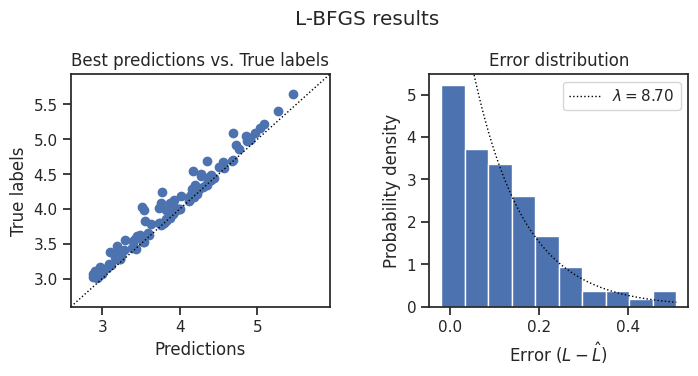

           INFO     Loss predictor:                                                                     ]8;id=733890;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py\core.py]8;;\:]8;id=772339;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py#380\380]8;;\
                                                                                                                   
                      L(N, D) = 1.569 + 1734. / (N ^ 0.4811) + 5193. / (D ^ 0.3937)                                
                                                                                                                   

[21:54:25] INFO     [102nd] 2.09e+18 FLOPs => 2.81e+07 params * 1.24e+10 samples                        ]8;id=411800;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py\core.py]8;;\:]8;id=11551;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/core.py#456\456]8;;\

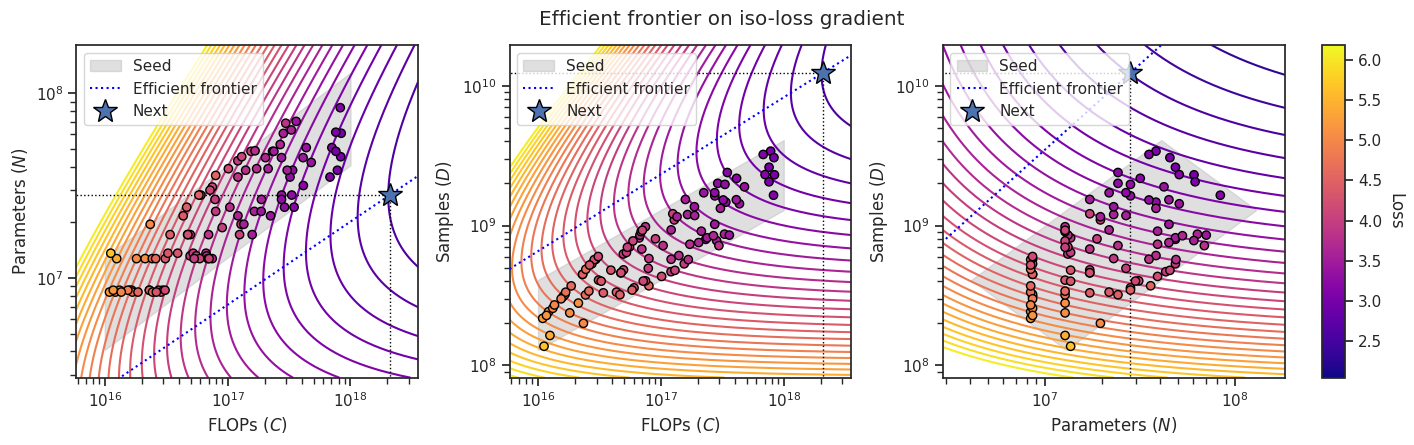

[21:54:27] INFO     Image saved to                                                                ]8;id=991856;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/visualizer.py\visualizer.py]8;;\:]8;id=216332;file:///opt/hpcaas/.mounts/fs-013ce0b72d8c07bba/margaretli/env_srcs/xlf/xlformers_n/scaling/visualizer.py#153\153]8;;\
                    /fsx-onellm/margaretli/env_srcs/xlf/xlformers_n/scaling/tmp2/simulation--para                  
                    metric_fit.png                                                                                 

In [7]:
cc_sim = Chinchilla(
    "/fsx-onellm/margaretli/env_srcs/xlf/xlformers_n/scaling/tmp2",
    param_grid=dict(
        E=np.linspace(1.1, 1.5, 5),
        A=np.linspace(200, 1000, 5),
        B=np.linspace(200, 1000, 5),
        alpha=np.linspace(0.1, 0.5, 5),
        beta=np.linspace(0.1, 0.5, 5),
    ),
    seed_ranges=dict(C=(1e16, 1e18), N_to_D=(10, 100)),
    # To search for the model configuration with N closest to suggested:
    model_search_config=dict(
        hyperparam_grid=dict(
            hidden_size=list(range(64, 16384 + 1, 64)),
            num_hidden_layers=list(range(1, 50 + 1)),
            num_heads=list(range(1, 40 + 1)),
        ),
        size_estimator=estimate_model_size,  # You gotta define a function to estimate & return model size also
    ),
    # Parameters you may pre-set
    num_seeding_steps=100,
    scaling_factor=2.0,
)

cc_sim.simulate(
    num_seeding_steps=101,
    num_scaling_steps=1,
    scaling_factor=2.0,
    target_params=dict(
        E=1.969,
        A=495.8,
        B=127100,
        alpha=0.3912,
        beta=0.5708
    ),
    # Add exponentially distributed loss averaging at 0.1
    noise_generator=(random.expovariate, (10,))
)

In [23]:
for n, d, l in fit_df[['N', 'D', loss_name]].values:
    print(int(n), int(d), round(l, 4), round(cc.predict_loss(n, d), 4))
    n1,d1 = cc.allocate_compute(6* n * d)
    print(int(n1) , int(d1), round(cc.predict_loss(n1, d1), 4))
    print('\n')

12047168 209715200 4.985 4.985
1446383 1746753059 3.9531


12047168 262144000 4.781 4.7147
1651146 1912666390 3.8695


12047168 377487360 4.49 4.3408
2049987 2218380913 3.7417


12047168 524288000 4.122 4.0645
2491174 2535424990 3.6356


12047168 786432000 3.85 3.7877
3168759 2989901817 3.5152


12047168 1048576000 3.685 3.6267
3758569 3360951973 3.4364


16865856 209715200 4.953 4.9321
1765984 2002864097 3.8286


16865856 262144000 4.744 4.6618
2015993 2193103841 3.7512


16865856 524288000 4.019 4.0116
3041638 2907172057 3.5349


16865856 786432000 3.732 3.7348
3868946 3428284824 3.4236


16865856 1048576000 3.605 3.5738
4589084 3853738801 3.3507


16865856 1310720000 3.53 3.4659
5238757 4219781750 3.2975


16865856 1572864000 3.476 3.3875
5837288 4544524366 3.256


25174528 262144000 4.708 4.6072
2556851 2581046499 3.622


25174528 377487360 4.371 4.2333
3174468 2993592775 3.5144


25174528 524288000 3.976 3.957
3857659 3421427712 3.4249


25174528 786432000 3.68 3.6802
4906920 4034

In [26]:
def optimal_allocation(N_BASE, D_BASE):
    min_l = float("inf")
    for i in np.linspace(1.0001, 10, 500):
        D =  D_BASE*i
        N = N_BASE/i
        new_l = cc.predict_loss(N, D)
        if new_l < min_l:
            min_l, min_t, min_s = new_l, D, N
        D =  D_BASE/i
        N = N_BASE*i
        new_l = cc.predict_loss(N, D)
        if new_l < min_l:
            min_l, min_t, min_s = new_l, D, N
    return min_l, min_t, min_s

for n, d, l in fit_df[['N', 'D', loss_name]].values:
    print(int(n), int(d))
    print(l)
    print(cc.predict_loss(n, d))
    l1,d1,n1 = optimal_allocation(n, d)
    print(int(n1) , int(d1))
    print(l1)
    print('\n')


12047168 209715200
4.985
4.984999999985012
1647441 1533574928
3.9547703446065237


12047168 262144000
4.781
4.718840361649338
1832775 1723120843
3.857229944365275


12047168 377487360
4.49
4.3450289422490425
2186788 2079603511
3.7099973379673847


12047168 524288000
4.122
4.063733022167047
2554807 2472274600
3.58925081094474


12047168 786432000
3.85
3.776513041645964
3100274 3055948513
3.4542959689303943


12047168 1048576000
3.685
3.606400257281166
3563370 3545062514
3.3671463347407986


16865856 209715200
4.953
4.940336312211292
1938288 1824819455
3.8099082988155475


16865856 262144000
4.744
4.674176673875618
2152438 2054080532
3.720864675706088


16865856 524288000
4.019
4.019069334393327
3002493 2945074156
3.4762293855438813


16865856 786432000
3.732
3.7318493538722444
3646426 3637491967
3.353030711009378


16865856 1048576000
3.605
3.5617365695074463
4184944 4225893875
3.2734723435468744


16865856 1310720000
3.53
3.4461957838073793
4641973 4762287832
3.215892463897352


168658